# Homework 2

This homework covers Lectures 10-11. Please take a look at the material for the context and notation. You have three weeks to complete the homework.

In this homework we will study minimax problems. We will begin with some theoretical analysis and in a second part you will implement a simple GAN with a small generator and a dual variable. 

These notebooks should expose you to the fundamentals of GAN training at a basic level, as well as some of the theory behind it.

Please write the names of your collaborators here:

## 1. Minimax problems - (50 points)

### 1.1 Theoretical recap: stationary points and convergence in minmax games

Consider a stylized function $f: \mathbb{R}^2 \to \mathbb{R}$, such that we have $f(x, y)=(x-1)(y-1).$

__(1)__ (5 points) Write down the first-order stationary points of $f$, and
        classify them as local minimum, local maximum, or saddle point by
        inspecting its Hessian.

$\textbf{Ans.}$ $f_x(x,y) = y-1$ and $f_y(x,y) = x-1$,$(f_x$,$f_y$ represent partial derivatives of f) thus the stationary point is (x,y) = (1,1) since $f_x(1,1)=f_y(1,1) = 0$.

$$
f(x,y) = xy - x - y + 1\\ f_{xx}(x,y) = f_{yy}(x,y) = 0\\ f_{xy}(x,y) = f_{yx}(x,y) = 1\\
Hessian = \begin{bmatrix}
0 & 1\\
1 & 0
\end{bmatrix}
$$
The $Det(Hessian) = -1$ thus we conclude that the point (x,y) = (1,1) is the only critical point and it is a saddle point.

__(2)__ (5 points) Show that $(x^\star,y^\star)=(1,1)$ is a solution to the
        minimax problem $\min_x \max_y f(x, y)$. You can characterize the solution
        by using the following saddle point inequality:  $f(x^\star, y^\star)
        \geq f(x^\star, y)$ and $f(x^\star, y^\star) \leq f(x, y^\star)$, for
        all $x, y$.

__(3)__ (10 points) One possible attempt at finding this solution via iterative
        first-order methods is to perform gradient updates on the variables $x$
        and $y$. More precisely for $\gamma > 0$ consider the simultaneous gradient
        descent/ascent updates
        
$$
    x_{k+1} = x_k - \gamma \nabla_x f(x_k, y_k), \qquad
    y_{k+1} = y_k + \gamma \nabla_y f(x_k, y_k)
$$
Show that the sequence of iterates $\{x_k, y_k \}_{k=0}^\infty$ starting
from any point $(x_0, y_0) \neq (1, 1)$ diverges, for any $\gamma > 0$.
Find the rate at which the distance from 
$(x^\star,y^\star)$ to the sequence $\{x_k, y_k \}$ grows as the number of iterations $k$ increases.

### 1.2 A concrete example: Rock - Paper - Scissors

To make your previous abstract analysis more concrete, we will now look at the classic Rock-Paper-Scissors game.

We can be formalize the game as follows. There are two players, the `x` player and the `y` player. There is only one single round. The players play a randomized strategy: each player chooses a probability of playing rock/paper/scissor. We look at the expected pay-off of these randomized strategies. 

In other words, the players choose an element in $\Delta_3$ the probability simplex in dimension 3. The `x` player chooses a vector $\mathbf{x} = \begin{bmatrix} \mathbf{x}_1 & \mathbf{x}_2 & \mathbf{x}_3 \end{bmatrix} \in \Delta_3$where $\mathbf{x}_1$ is the probability of playing `Rock`, $\mathbf{x}_2$ is the probability of playing `Paper`, $\mathbf{x}_3$ is the probability of playing `Scissors`. The `y` player chooses a vector $\mathbf{y} \in \Delta_3$ defined in the same way. 

The game designers decide that winning the game gives 1 point and a tie gives 0 points. So the expected payoff for a given choice of strategies $\mathbf{x}, \mathbf{y}$ is obtained by computing:
$$
\mathbf{x}^\top \begin{bmatrix} 0 & 1 & -1 \\ -1 & 0 & 1 \\ 1 & -1 & 0\end{bmatrix}\mathbf{y}
$$

This objective is from the perspective of the `y` player who wants to obtain/get points and the `x` player who wants to give/loose as few points as possible. The `x` player wants to minimize this expected payoff and the `y` player wants to maximize it. So the problem we seek to solve is

$$
\min_{\mathbf{x} \in \Delta_3} \max_{\mathbf{y} \in \Delta_3} \mathbf{x}^\top \mathbf{M}\mathbf{y} =: f(\mathbf{x}, \mathbf{y})
$$
with $\mathbf{M} = \begin{bmatrix} 0 & 1 & -1 \\ -1 & 0 & 1 \\ 1 & -1 & 0\end{bmatrix}$.

In the following cells, you will implement methods to solve this game and find the optimal strategies.

In [2]:
from lib.utils import *

**(1)** (1 points) Implement the objective function $f$ given two 3 dimensional vectors `x` and `y` stored as `torch.Tensor` objects.

In [3]:
def f(x: torch.Tensor, y: torch.Tensor):
    M = torch.tensor([[0, 1, -1], [-1, 0, 1], [1, -1, 0]], dtype=torch.float32)
    return torch.matmul(x,torch.matmul(M,y))

**(2)** (10 points) Implement a single step of the simultaneous gradient descent/ascent studied in question 1.1.(3). Since we are in a constrained setting, make sure you include a projection step onto the simplex.

The function `GDA` you will implement takes in the objective function `f`, the two current strategies of the players stored in tensors `x` and `y` and a step_size. Write the function so that it modifies the variables `x` and `y` in place without returning anything.

We provide you with a function called `simplex_project` that projects a vector on the probability simplex. The function has no return value and does the projection in place. Use `Pytorch` to compute gradients automatically. 

__Hints__: Review what a call to `.backward()` on a tensor does. Review what in-place operations are like. Think of which steps need to be in a `with torch.no_grad()` block. Remember to zero the gradients before re-using them.

In [4]:
def GDA(f, x, y, step_size):
    payoff = f(x, y)

    # to calculate gradients with respect to the payoff function
    payoff.backward()
    
    #iterate update steps should not be part of gradient computation
    with torch.no_grad():
        x -= step_size * x.grad
        y += step_size * y.grad
        simplex_project(x)
        simplex_project(y)
    
    #to avoid accumulation of the gradients
    x.grad.zero_()
    y.grad.zero_()

We can run this algorithm initialized from trivial strategies of always playing Rock vs always playing Paper. Notice here that you can set the step_size and the number of iterations.

In [5]:
x_init = torch.tensor([1.0, 0.0, 0.0])
y_init = torch.tensor([0.0, 1.0, 0.0])

gda_x_sequence, gda_y_sequence = run_alg(GDA, f, x_init, y_init, step_size=0.02, n_iterations=1000)

We can visualize this sequence in two dimensions since the simplex $\Delta_3$ is a 2-dimensional.

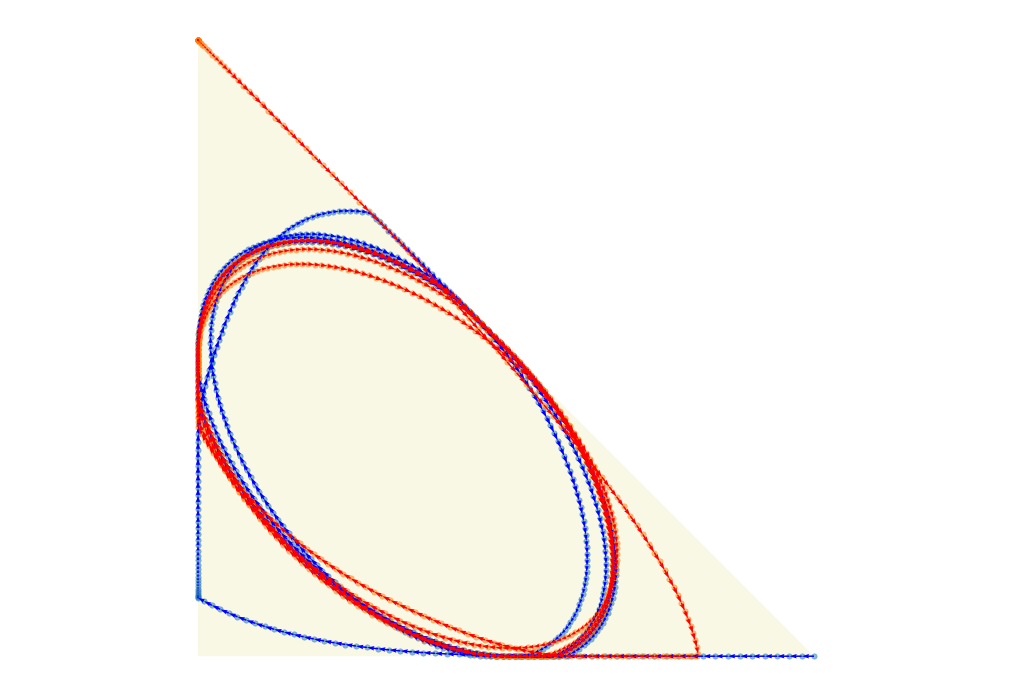

In [6]:
visualize_seq(gda_x_sequence, gda_y_sequence)

**(3)** (4 points)  What kind of behavior do you observe ? Do the iterates converge ? Play with the step_size and the number of iterations.

We observe that the simplex is moving around without showing any signs of convergence. The iterates do not coverge. We know that the optimal point is at the centre of the triangle, but we observe that the iterates go around it in circles.

**(4)** (15 points)As you've shown both theoretically and in practice, simultaneous Gradient Descent Ascent (sGDA) cannot solve the problem. You will now implement `ExtraGradient`, an algorithm that can solve bilinear games.

As dicussed in class, the idea behind extra-gradient is to approximate an implicit update with a more tractable one. 

Consider the following implicit updates:
$$
    x_{k+1} = x_k - \gamma \nabla_x f({\color{red}{x_{k+1}, y_{k+1}}}) \\
    y_{k+1} = y_k + \gamma \nabla_y f({\color{red}{x_{k+1}, y_{k+1}}})
$$

Computing the next iterates $x_{k+1}, y_{k+1}$ requires you to solve a fixed point problem because we are evaluating the gradient at the unknown next iterate.  As this is too costly, we circumvent this difficulty by doing an _extrapolation_ step. Define the half steps:

$$
    x_{k+1/2} = x_k - \gamma \nabla_x f(x_k, y_k) \\
    y_{k+1/2} = y_k + \gamma \nabla_y f(x_k, y_k)
$$

These half step extrapolation variables will help us to approximate the implicit iterates. We can then write
$$
    x_{k+1} = x_k - \gamma \nabla_x f({\color{green}{x_{k+1/2}, y_{k+1/2}}}) \\
    y_{k+1} = y_k + \gamma \nabla_y f({\color{green}{x_{k+1/2}, y_{k+1/2}}})
$$
The recursion above defines the ExtraGradient algorithm. As we are in a constrained setting however, you need to project both the half steps and the algorithm iterates onto the constraint set.

Implement `ExtraGradient` below.

**Hint**: Review what `.retain_grad()` does. Remember you are given `simplex_project`.


In [7]:
def ExtraGradient(f, x, y, step_size):
    payoff = f(x, y)
    payoff.backward()

    half_x = x - step_size * x.grad
    half_y = y + step_size * y.grad

    x.grad.zero_()
    y.grad.zero_()

    half_x.retain_grad()
    half_y.retain_grad()

    payoff2 = f(half_x, half_y)
    payoff2.backward()

    with torch.no_grad():
        x-= step_size * half_x.grad
        y+= step_size * half_y.grad
        simplex_project(x)
        simplex_project(y)
    
    x.grad.zero_()
    y.grad.zero_()
        

We can visualize the progression of the algorithm by running the cells below:

In [8]:
eg_x_sequence, eg_y_sequence = run_alg(ExtraGradient, f, x_init, y_init, 0.5)

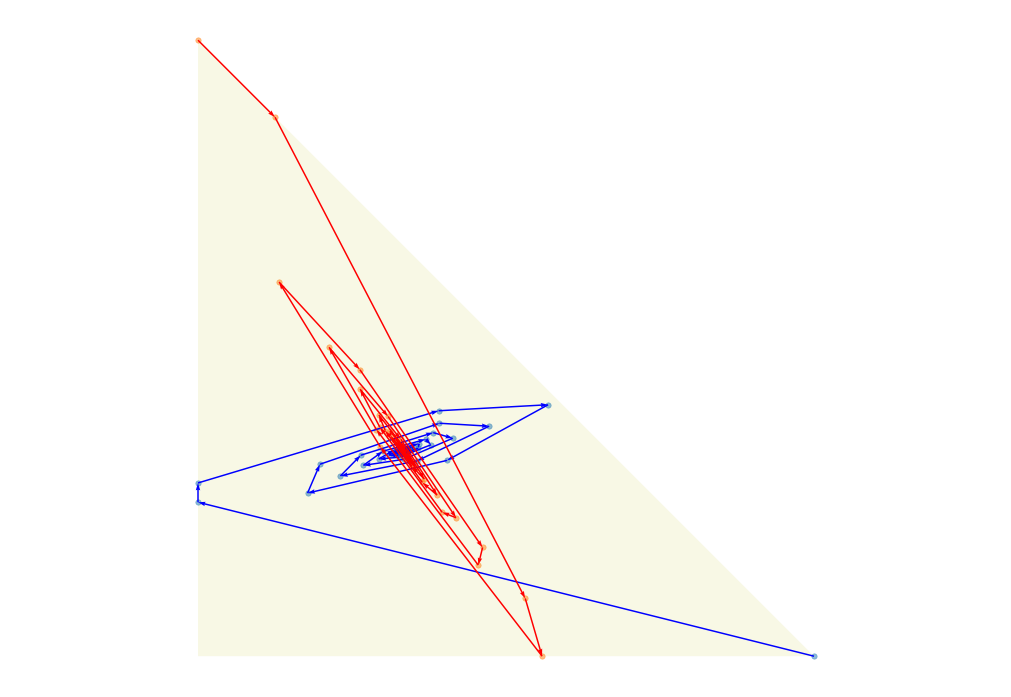

In [9]:
visualize_seq(eg_x_sequence, eg_y_sequence)

You should observe convergence to the optimal strategy in this case which happens to be playing a uniform strategy for both players, i.e, $\mathbf{x}^\star = \mathbf{y}^\star = \begin{bmatrix} 1/3 & 1/3 & 1/3\end{bmatrix}$.

In the next notebook, now that you know now all the difficulties there are in solving a min-max objective, you will implement a GAN, one of the more prominent min-max problems in machine learning.